In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn import __version__
from sklearn import set_config

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import (
    cross_validate,
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)
from sklearn.metrics import make_scorer

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import (
    OrdinalEncoder,
    PolynomialFeatures,
    PowerTransformer,
    QuantileTransformer,
    StandardScaler,
)

from sklearn.impute import (
    KNNImputer,
    SimpleImputer
)

from sklearn.cluster import KMeans

from category_encoders import CatBoostEncoder

from lightgbm import LGBMRegressor

import phik
from phik.report import plot_correlation_matrix

from matplotlib import pyplot as plt
import seaborn as sns

import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

print('The scikit-learn version is {}.'.format(__version__))

pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_columns', None)

set_config(transform_output="pandas")

RANDOM_STATE = 12345

/kaggle/input/used-cars-price-prediction-67ds/sample_submission.csv
/kaggle/input/used-cars-price-prediction-67ds/train.csv
/kaggle/input/used-cars-price-prediction-67ds/test.csv
The scikit-learn version is 1.2.2.


# Подготовка данных

In [3]:
train_path = '/kaggle/input/used-cars-price-prediction-67ds/train.csv'
test_path = '/kaggle/input/used-cars-price-prediction-67ds/test.csv'

try:
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
except Exception as e:
    print('Ошибка загрузки данных', e)

In [4]:
display(train_data.head())
display(test_data.head())

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.20,"111,041.00",black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.50,"31,034.00",black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.20,"35,619.00",black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.80,"131,301.00",gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.00,"127,709.00",black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.70,"116,970.00",silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.40,"6,286.00",white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.60,"11,831.00",gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.30,"57,105.00",silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.90,"31,083.00",black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)


In [5]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110058 entries, 0 to 110057

In [6]:
display(train_data.describe().T)
display(test_data.describe().T)

,count,mean,std,min,25%,50%,75%,max
year,"440,236.00","2,010.04",3.98,"1,982.00","2,007.00","2,012.00","2,013.00","2,015.00"
condition,"430,831.00",3.43,0.95,1.00,2.70,3.60,4.20,5.00
odometer,"440,167.00","68,344.42","53,542.20",1.00,"28,258.00","52,098.00","99,272.00","999,999.00"
sellingprice,"440,236.00","13,592.21","9,751.48",1.00,"6,900.00","12,100.00","18,200.00","230,000.00"


,count,mean,std,min,25%,50%,75%,max
year,"110,058.00","2,010.06",3.96,"1,982.00","2,007.00","2,012.00","2,013.00","2,015.00"
condition,"107,679.00",3.42,0.95,1.00,2.70,3.60,4.20,5.00
odometer,"110,039.00","68,074.33","53,520.99",1.00,"28,313.50","51,922.00","98,852.50","999,999.00"


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


CPU times: user 3min 23s, sys: 3.37 s, total: 3min 27s
Wall time: 3min 23s


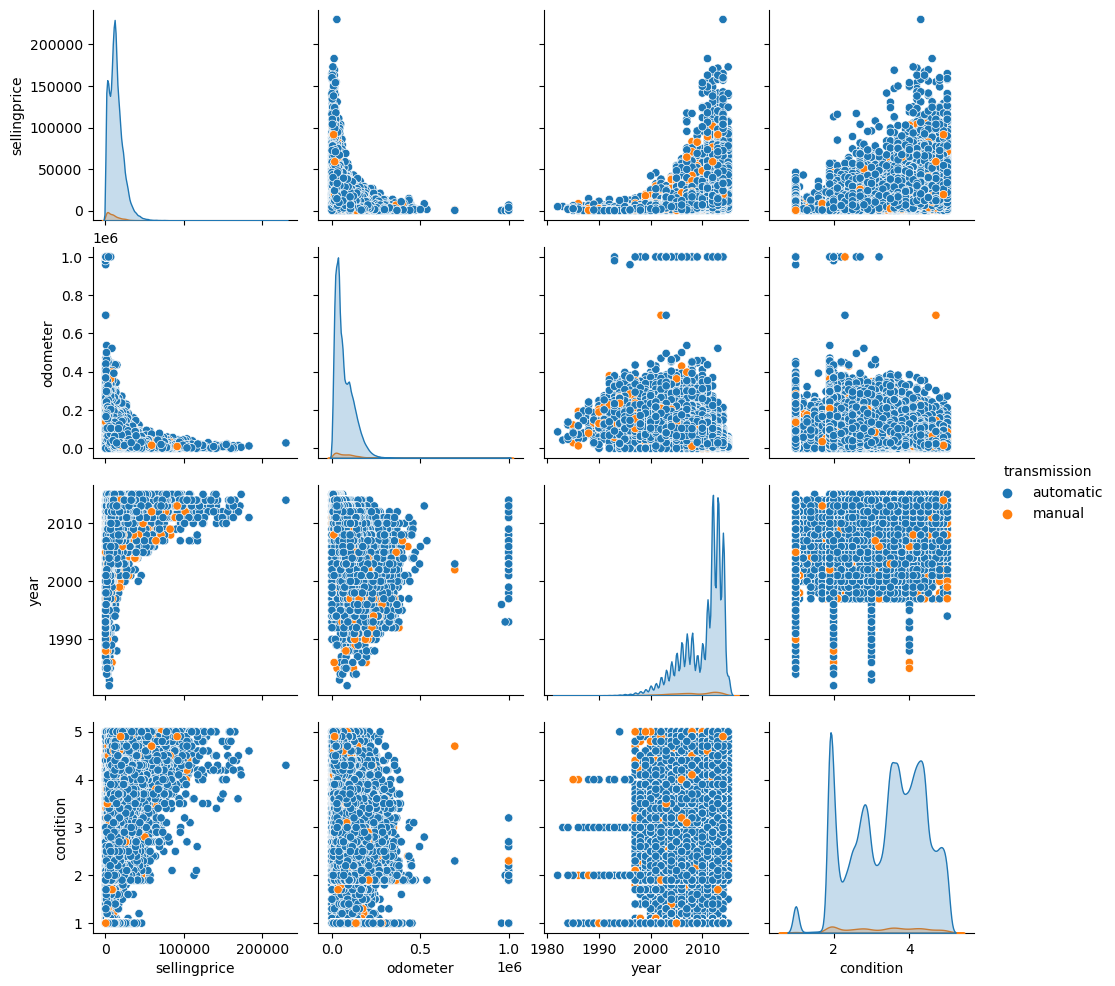

In [7]:
%%time
# ~ 2-3 min
_ = sns.pairplot(
    train_data[['sellingprice', 'odometer', 'year', 'condition', 'transmission']],
    hue='transmission')

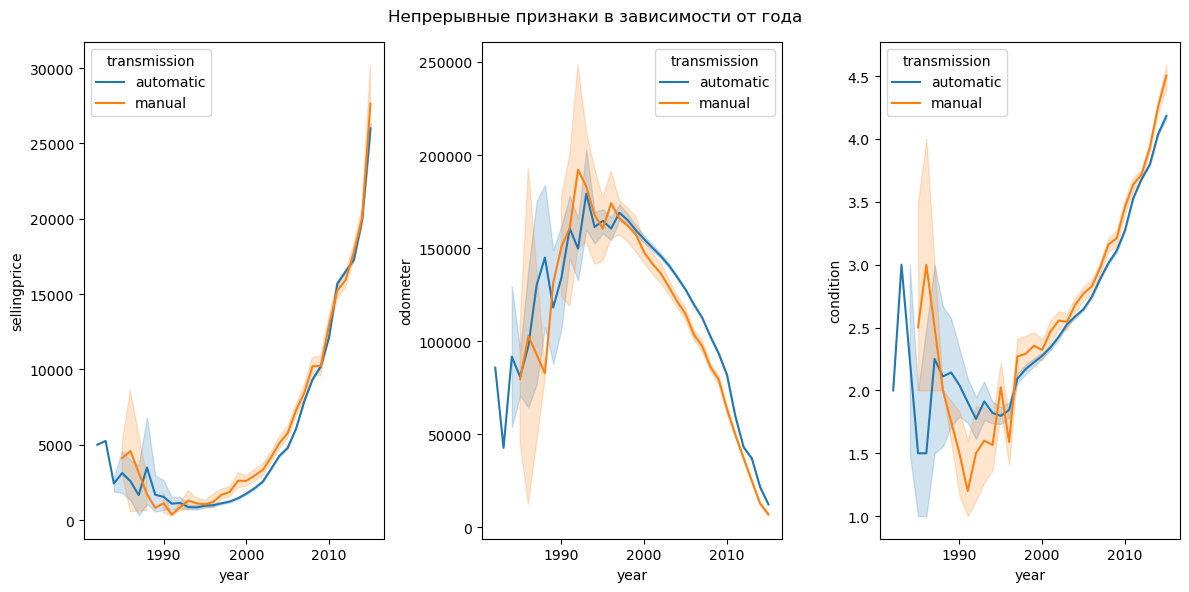

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

sns.lineplot(
    ax=axes[0],
    x="year",
    y="sellingprice",
    hue='transmission',
    data=train_data)

sns.lineplot(
    ax=axes[1],
    x="year",
    y="odometer",
    hue='transmission',
    data=train_data)

sns.lineplot(
    ax=axes[2],
    x="year",
    y="condition",
    hue='transmission',
    data=train_data)

plt.suptitle('Непрерывные признаки в зависимости от года')
plt.tight_layout()
plt.show()

In [9]:
def bar(data, column, ax, title, nlargest=0):
    ax.set_ylabel('Частота')
    df = data[column].value_counts()
    if nlargest:
        df = df.nlargest(nlargest)
        title += f' (top-{nlargest})'
    return df.plot.bar(ax=ax, title=title, grid=True)

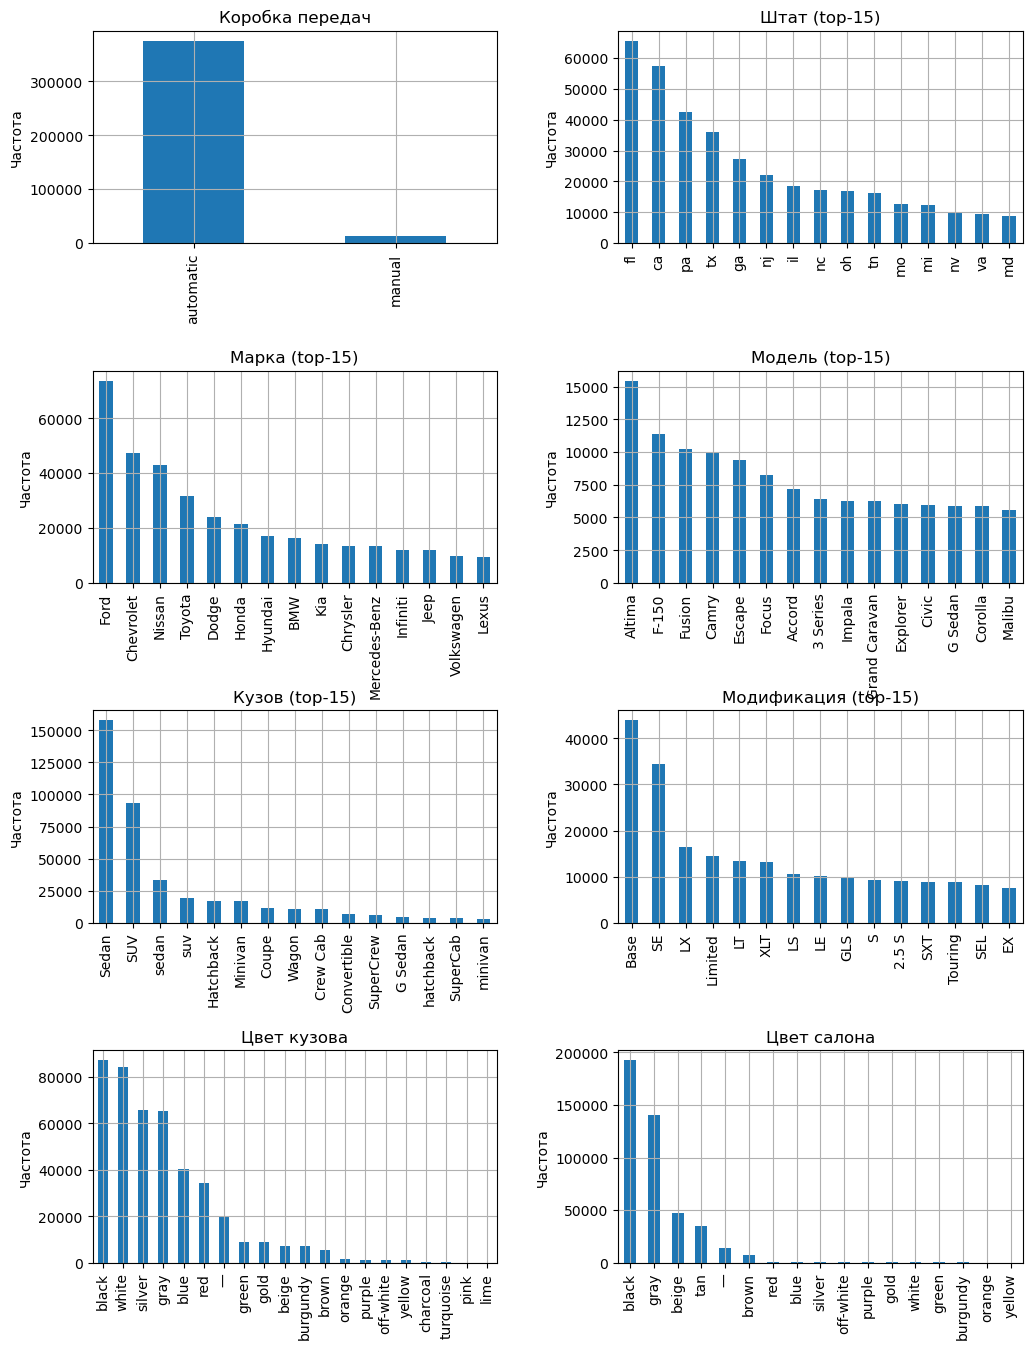

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))

lim = 15
bar(train_data, 'transmission', axes[0][0], title='Коробка передач')
bar(train_data, 'state', axes[0][1], title='Штат', nlargest=lim)

bar(train_data, 'make', axes[1][0], title='Марка', nlargest=lim)
bar(train_data, 'model', axes[1][1], title='Модель', nlargest=lim)

bar(train_data, 'body', axes[2][0], title='Кузов', nlargest=lim)
bar(train_data, 'trim', axes[2][1], title='Модификация', nlargest=lim)

bar(train_data, 'color', axes[3][0], title='Цвет кузова')
bar(train_data, 'interior', axes[3][1], title='Цвет салона')

plt.subplots_adjust(wspace=0.3, hspace=0.6)
plt.show()

## Аномалии
Редкие значения, выборосы

In [11]:
class DataState:
    '''
    Вспомогательный класс для отслеживания количества записей.
    Удобно отображать количество удаленных записей.
    '''
    def __init__(self, df):
        self.data = df
        self.orig_data_len = df.shape[0]
        self.curr_data_len = df.shape[0]

    def check(self):
        curr_data_len = self.data.shape[0]
        print(f'Удалено: {self.curr_data_len - curr_data_len}')
        ratio = (self.orig_data_len - curr_data_len) / self.orig_data_len
        print(f'Удалено всего: {self.orig_data_len - curr_data_len}, что составляет {ratio:.2%}')
        self.curr_data_len = curr_data_len

data_state = DataState(train_data)

### Год

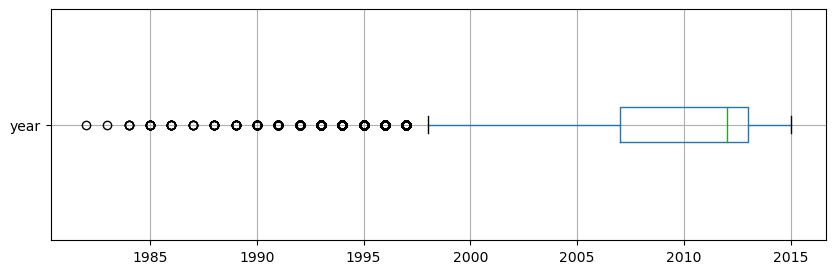

In [12]:
train_data.boxplot(column='year', figsize=(10, 3), vert=False)
plt.show()

### Odometer

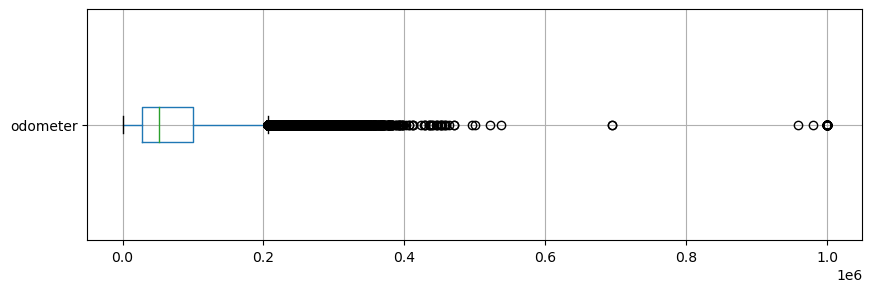

Удалено: 1363
Удалено всего: 1363, что составляет 0.31%


In [13]:
train_data.boxplot(column='odometer', figsize=(10, 3), vert=False)
plt.show()

# # Удаление аномалий
condition_low = 'odometer < 50'
train_data.drop(train_data.query(condition_low).index, inplace=True)
condition_high = 'odometer == 999_999'
train_data.drop(train_data.query(condition_high).index, inplace=True)
data_state.check()

### Sellingprice

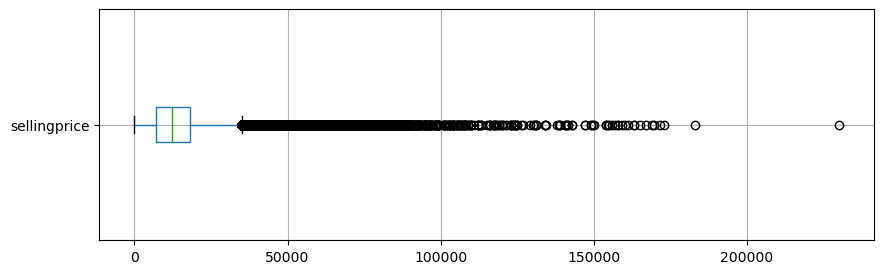

Нижняя граница отсечения аномалий: 100
Удалено: 1
Удалено всего: 1364, что составляет 0.31%


In [14]:
train_data.boxplot(column='sellingprice', figsize=(10, 3), vert=False)#.set_xlim(0, top_interq)
plt.show()

# Нижняя граница отсечения аномалий
price_bottom_threshold = 100
print(f'Нижняя граница отсечения аномалий: {price_bottom_threshold}')

train_data.drop(train_data.query('sellingprice < @price_bottom_threshold').index, inplace=True)
data_state.check()

## Пропущенные значения

In [15]:
def missed_values_barh(df):
    df_null = (
        (df.isna().mean() * 100)
        .to_frame()
        .rename(columns = {0: 'ratio'})
        .query('ratio > 0')
        .sort_values(by='ratio', ascending=True)
    )
    if df_null.shape[0]:
        ax = df_null.plot(kind='barh', figsize=(12, 3), legend=False, title='Пропущенные значения, %')
        for i in ax.patches:
            plt.text(i.get_width() + 0.02, i.get_y() + 0.2,
                     str(round((i.get_width()), 2)),
                     color='black')
        plt.show()
    else:
        print('Пропущенных значений нет')

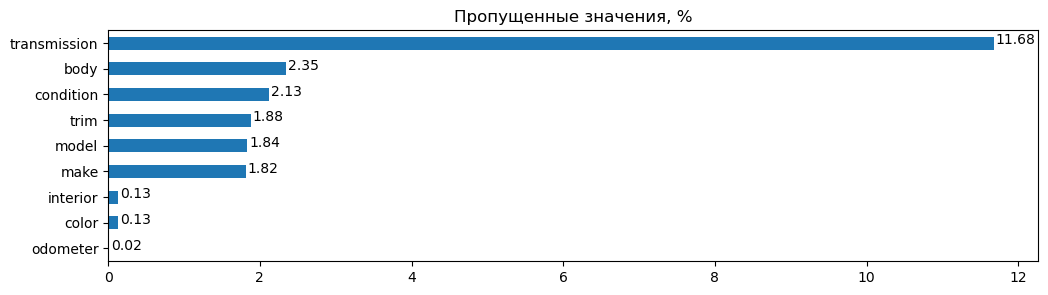

In [16]:
missed_values_barh(train_data)

In [17]:
# Удаление мусора (ничего не известно о том, что это за автомобиль)
train_data.drop(train_data.query('trim.isna() and model.isna() and make.isna() and body.isna()').index, inplace=True)
data_state.check()

Удалено: 7979
Удалено всего: 9343, что составляет 2.12%


## Дубликаты

In [18]:
def rem_cat_duplicates(data):
    # Перевод в нижний регистр
    categories = [
        'make',
        'model',
        'trim',
        'body',
        'transmission',
        'state',
        'color',
        'interior',
        'seller'
    ]

    for cat in categories:
        data[cat] = data[cat].str.lower()
        print(f'{cat}: {data[cat].nunique()}')

    # Дубликаты марок
    makes = {
        'mercedes': 'mercedes',
        'dodge': 'dodge',
        'ford': 'ford',
        'gmc': 'gmc',
        'land': 'land rover',
        'mazda': 'mazda',
        'vw': 'volkswagen',
        'chev': 'chevrolet',
        'hyundai': 'hyundai'
    }

    for key, value in makes.items():
        qry_str = f'make.str.startswith(@key, na=False)'
        data.loc[data.query(qry_str, engine='python').index, 'make'] = value

In [19]:
rem_cat_duplicates(train_data)

make: 62
model: 838
trim: 1848
body: 45
transmission: 2
state: 38
color: 20
interior: 17
seller: 12801


In [20]:
print(f'Количество дубликатов: {train_data[train_data.duplicated()].shape[0]}')

Количество дубликатов: 0


## Мультиколлинеарность
Признаки *seller* и *trim* имеют большое число категорий, поэтому они перекодируются в числовые значения с помощью CatBoostEncoder. Это делается только для того, чтобы отобразить матрицу корреляции phik.

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


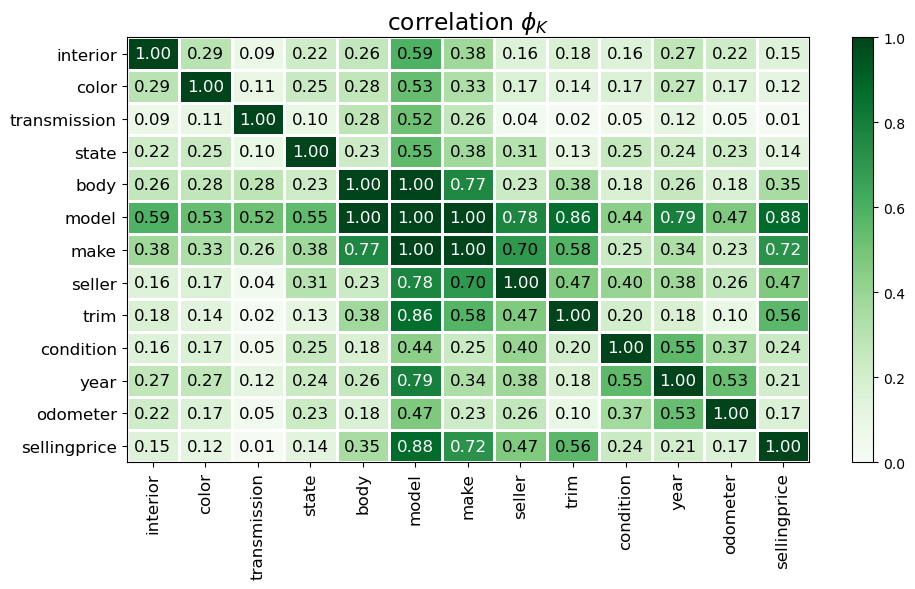

In [21]:
train_data_phik = CatBoostEncoder(
    cols=['trim', 'seller']).fit_transform(train_data, train_data['sellingprice'])

num_feature_names = [
    'sellingprice',
    'odometer',
    'year',
    'condition',
    'trim',
    'seller',
]

cat_feature_names = [
    'make',
    'model',
    'body',
    'state',
    'transmission',
    'color',
    'interior',
]

feature_names = num_feature_names + cat_feature_names

phik_overview = train_data_phik[feature_names].phik_matrix(interval_cols=num_feature_names)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.2,
                        figsize=(10, 6))
plt.tight_layout()

# ML

In [22]:
# Если истинная цена будет равна нулю, то здесь можно предусмотреть какое-то мелкое значение,
# которое прибавляется к y_true в знаменателе, чтобы избежать ошибки. Или использовать штатное MAPE от sklearn.
def mape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / y_true) * 100

scorer = make_scorer(mape, greater_is_better=False)

In [23]:
def print_result(est):
    print(f'best score: {-est.best_score_}')
    print(f'score std: {est.cv_results_["std_test_score"][est.best_index_]}')
    print(f'best params: {est.best_params_}')

In [24]:
def importance_plot(estimator):
    feat_imp = pd.Series(
        estimator.feature_importances_,
        index=estimator.feature_name_)
    feat_imp.nlargest(30).plot(
        kind='barh',
        figsize=(6, 3),
        title='Важность признаков').set_xlabel('importance_type="split"')
    plt.show()

In [25]:
class CustomNormalTransformer(BaseEstimator, TransformerMixin):
    '''
    Можно без этого вспомогательного класса, но через него можно подсмотреть,
    что передается в пайплайне.
    '''
    def __init__(self):
        self._estimator = QuantileTransformer(
            output_distribution='normal',
            random_state=RANDOM_STATE)

    def fit(self, X, y=None):
        self._estimator.fit(np.copy(X))
        return self

    def transform(self, X):
        return self._estimator.transform(np.copy(X))

    def inverse_transform(self, X):
        X_reversed = self._estimator.inverse_transform(np.copy(X))
        return X_reversed

## Feature Selection

In [26]:
num_feature_names = [
    'year',
    'condition',
    'odometer',
]

cat_feature_names = [
    'make',
    'model',
    'trim',
    'body',
    'transmission',
    'state',
    'seller',
]

feature_names = num_feature_names + cat_feature_names

X_train = train_data[feature_names]
y_train = train_data['sellingprice']

## LGBMRegressor

In [27]:
%%time

col_transformer_lgbm = ColumnTransformer(
    [
        ('num_scaler', StandardScaler(), num_feature_names),
        ('cat_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), cat_feature_names)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

model_lgbm = LGBMRegressor(
    objective='regression',
    max_bin=2000,
    force_col_wise=True,
    random_state=RANDOM_STATE,
    verbose=1,
)

pipeline_lgbm = Pipeline(steps=[
    ('preprocessing', col_transformer_lgbm),
    ('regression', TransformedTargetRegressor(
        regressor=model_lgbm, transformer=CustomNormalTransformer())
    )
])

param_grid_lgbm = {
    'regression__regressor__n_estimators': [1500],
    'regression__regressor__learning_rate': [0.05],
    'regression__regressor__num_leaves': [120], # возросла точность
    'regression__regressor__cat_smooth': [7, 8, 9], # немного возросла точность (дефолтное значение = 10)
    'regression__regressor__feature_fraction': [0.7],
}

gs_lgbm = GridSearchCV(
    pipeline_lgbm,
    param_grid=param_grid_lgbm,
    scoring=scorer,
    cv=3,
    n_jobs=-1,
    verbose=2,
    error_score='raise'
)

gs_lgbm.fit(
    X_train,
    y_train,
    regression__feature_name=feature_names,
    regression__categorical_feature=cat_feature_names,
)

print_result(gs_lgbm)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categori

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Total Bins 8537
[LightGBM] [Info] Number of data points in the train set: 287262, number of used features: 10
[LightGBM] [Info] Start training from score 0.019476
[CV] END regression__regressor__cat_smooth=7, regression__regressor__feature_fraction=0.7, regression__regressor__learning_rate=0.05, regression__regressor__n_estimators=1500, regression__regressor__num_leaves=120; total time=12.5min
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Total Bins 8534
[LightGBM] [Info] Number of data points in the train se

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Total Bins 8495
[LightGBM] [Info] Number of data points in the train set: 287262, number of used features: 10
[LightGBM] [Info] Start training from score 0.002735
[CV] END regression__regressor__cat_smooth=8, regression__regressor__feature_fraction=0.7, regression__regressor__learning_rate=0.05, regression__regressor__n_estimators=1500, regression__regressor__num_leaves=120; total time=12.3min
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Total Bins 8537
[LightGBM] [Info] Number of data points in the train se

/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Total Bins 8478
[LightGBM] [Info] Number of data points in the train set: 430893, number of used features: 10
[LightGBM] [Info] Start training from score 0.010813
best score: 11.926835366447046
score std: 0.09079962429753097
best params: {'regression__regressor__cat_smooth': 8, 'regression__regressor__feature_fraction': 0.7, 'regression__regressor__learning_rate': 0.05, 'regression__regressor__n_estimators': 1500, 'regression__regressor__num_leaves': 120}
CPU times: user 2min 56s, sys: 32.9 s, total: 3min 29s
Wall time: 29min 18s


In [28]:
gs_lgbm.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_scaler',
                                                  StandardScaler(),
                                                  ['year', 'condition',
                                                   'odometer']),
                                                 ('cat_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['make', 'model', 'trim',
                                                   'body', 'transmission',
                                                   'state', 'seller'])],
                                   verbose_feature_names_out=False)),
                ('regression',
                 TransformedTargetRegressor(regressor=LGBMRegressor(cat_smooth=8,
                                                                    feature_fraction=0.7,
                                                                    force_col_wise=True,
                                                                    learning_rate=0.05,
                                                                    max_bin=2000,
                                                                    n_estimators=1500,
                                                                    num_leaves=120,
                                                                    objective='regression',
                                                                    random_state=12345,
                                                                    verbose=1),
                                            transformer=CustomNormalTransformer()))])

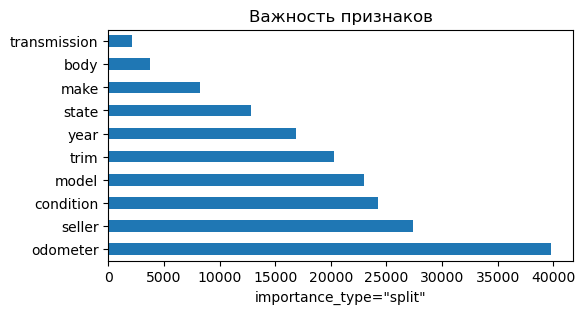

In [29]:
importance_plot(gs_lgbm.best_estimator_['regression'].regressor_)

In [30]:
# Обзор параметров и полученных метрик
df = pd.DataFrame(gs_lgbm.cv_results_['params'])
df['score'] = -gs_lgbm.cv_results_['mean_test_score']
df.sort_values(by='score')

,regression__regressor__cat_smooth,regression__regressor__feature_fraction,regression__regressor__learning_rate,regression__regressor__n_estimators,regression__regressor__num_leaves,score
1,8,0.70,0.05,1500,120,11.93
0,7,0.70,0.05,1500,120,11.93
2,9,0.70,0.05,1500,120,11.94


# Тестирование

In [31]:
def roll_out(data, condition, start=250_000, add=100, col='odometer'):
    cnt, value = 0, start
    for row in data.query(condition).itertuples():
        cnt += 1
        value += add
        data.loc[row.Index, col] = value
    print(f'condition: {condition}; total rows: {cnt}; last value: {value}')

In [32]:
# Обрабатываем мусорные записи
test_data['make'].fillna('nissan', inplace=True)
test_data['model'].fillna('altima', inplace=True)
test_data['body'].fillna('sedan', inplace=True)
test_data['trim'].fillna('base', inplace=True)

# "Раскатываем" аномальные одометры на значения бльше 250 тыс. - так лучше для метрики
# Можно попробовать объяснить это тем, что для этих одометров в основном плохие состояния или древние года, а значит
# можно предположить большой (адекватный) пробег
roll_out(test_data, condition_low)
roll_out(test_data, condition_high, add=48)

# Перевод категорий в нижний регистр, чистка марок автомобилей
rem_cat_duplicates(test_data)

condition: odometer < 50; total rows: 312; last value: 281200
condition: odometer == 999_999; total rows: 17; last value: 250816
make: 58
model: 746
trim: 1457
body: 42
transmission: 2
state: 38
color: 20
interior: 17
seller: 7623


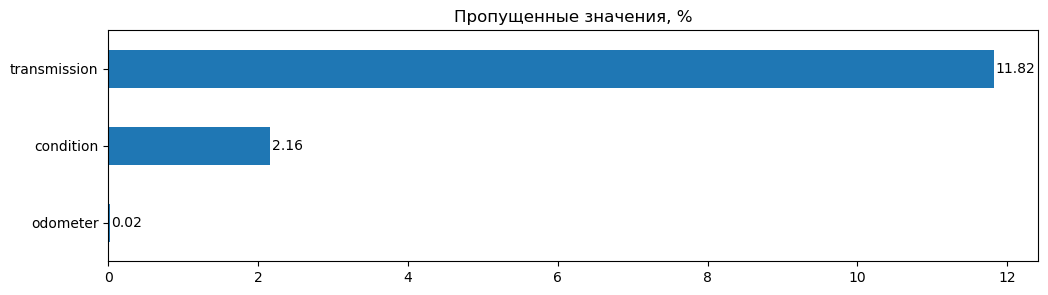

In [33]:
missed_values_barh(test_data[feature_names])

In [34]:
predictions = gs_lgbm.predict(test_data[feature_names])

In [35]:
output = pd.DataFrame({'vin': test_data.vin, 'sellingprice': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Total Bins 8534
[LightGBM] [Info] Number of data points in the train set: 287262, number of used features: 10
[LightGBM] [Info] Start training from score 0.007785
[CV] END regression__regressor__cat_smooth=7, regression__regressor__feature_fraction=0.7, regression__regressor__learning_rate=0.05, regression__regressor__n_estimators=1500, regression__regressor__num_leaves=120; total time=12.8min
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Total Bins 8495
[LightGBM] [Inf

# Выводы

- Метрика MAPE несимметричная: наболее сильно штрафуются ошибки на низких ценах.
    - Модели с высоким значением одометра (больше 100 тыс) как правило имеют низкие цены. Если убрать из выборки записи с высоким значением одометра, метрика кардинально снижается до 8-9.
- Что повлияло на снижение метрики:
    - Модель LightGBMRegressor: градиентный бустинг, нативная работа с категориями (в том числе с редкими) и пустыми значениями признаков.
    - Настройка гиперпараметров: низкий шаг обучения, большое количество деревьев, листьев, регуляризатор для редких категорий.
    - Приведение целевого признака к нормальному распределению с помощью QuantileTransformer.
    - Обработка данных: мусор (одновременно пустые марка, модель, комплектация, кузов), пустые значения категорий, аномалии одометра. Что примечательно, обработка данных внесла наименьший вклад в снижение метрики.